# Comparison of Neural Models 2

Following an experiment to compare neural models, we discovered odd results showing that bag of words could outperform embeddings. This experiment attempts to tweak the embeddings to show the expected results under the assumption that the problem is not the amount of data. If the problem is the amount of data we will investigate this in another experiment.

Again, we will show Bag of Words results:

In [1]:
from scripts import training_helpers
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding
from tensorflow.keras.regularizers import l2
from pandas import DataFrame
from seaborn import boxplot
import matplotlib.pyplot as plt
import json

import gensim
import numpy as np

read_existing_embeddings = True

Using TensorFlow backend.


In [2]:
data_frame = training_helpers.get_data_frame()
raw_features = data_frame['review']
labels = [x for x in data_frame['deceptive']]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_features)
bow_features = tokenizer.texts_to_matrix(raw_features, mode='tfidf')

In [3]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1

In [4]:
def get_ff_bow_model():
  model = Sequential([
      Dense(16, activation=relu, input_shape=(corpus_vocab_size,), kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

ff_bow_scores = run_cross_validate(get_ff_bow_model, bow_features, labels, cv=10, verbose=0)

Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 144us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 155us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 139us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 172us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 172us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 190us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 199us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 219us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 129us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 196us/step


In [5]:
embedding_matrix = None
embedding_length = 0
if read_existing_embeddings:
  # TODO why are so many entries to the embedding matrix all zeros?
  embedding_length=300
  embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
  with open('data.json', 'r') as infile:
      data = json.load(infile)
      for i in range(len(data)):
          embedding_matrix[i] = np.array(data[i], dtype=np.float32)
else:
  word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin",
                                                                 binary=True)
  embedding_length = word_vectors.vector_size
    
  embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
  for word, index in corpus_words.items():
    if word in word_vectors.vocab:
      embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

  with open('data.json', 'w') as outfile:
      json.dump(embedding_matrix.tolist(), outfile)

In [6]:
def get_ff_wv_model():
  model_ff_wv = Sequential([
      Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], trainable=False,
                input_length=corpus_vocab_size),
      Flatten(),
      Dense(16, activation=relu, kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model_ff_wv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_ff_wv

In [7]:
ff_wv_scores = run_cross_validate(get_ff_wv_model, bow_features, labels, cv=5)

Fitting with:  (1280, 9839) labels (1280,)
Train on 896 samples, validate on 384 samples
Epoch 1/12
896/896 [==============================] - 42s 47ms/step - loss: 1.0891 - acc: 0.5882 - val_loss: 1.2110 - val_acc: 0.6198
Epoch 2/12
896/896 [==============================] - 38s 43ms/step - loss: 1.2013 - acc: 0.7132 - val_loss: 1.3584 - val_acc: 0.6745
Epoch 3/12
896/896 [==============================] - 38s 42ms/step - loss: 1.2186 - acc: 0.7333 - val_loss: 1.4261 - val_acc: 0.7005
Epoch 4/12
896/896 [==============================] - 38s 42ms/step - loss: 1.2512 - acc: 0.7054 - val_loss: 1.3712 - val_acc: 0.6484
Epoch 5/12
320/320 [==============================] - 2s 7ms/step
Fitting with:  (1280, 9839) labels (1280,)
Train on 896 samples, validate on 384 samples
Epoch 1/12
896/896 [==============================] - 42s 47ms/step - loss: 0.9364 - acc: 0.5569 - val_loss: 1.0129 - val_acc: 0.6198
Epoch 2/12
896/896 [==============================] - 40s 44ms/step - loss: 1.1214 - a

In [8]:
print ("Bag of words: ", ff_bow_scores['accuracies'])
print ("Word vectors: ", ff_wv_scores['accuracies'])

ff_scores_entries =[('Bag of Words', x) for x in ff_bow_scores['accuracies']] + [('Word Vectors', x) for x in ff_wv_scores['accuracies']]
ff_scores_data_frame = DataFrame(ff_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.875, 0.8625, 0.88125, 0.88125, 0.86875, 0.91875, 0.875, 0.8625, 0.88125, 0.8875]
Word vectors:  [0.628125, 0.709375, 0.665625, 0.703125, 0.659375]


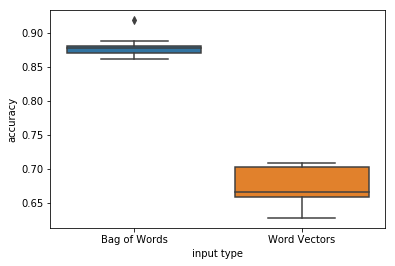

In [9]:
boxplot(x='input type', y='accuracy', data=ff_scores_data_frame)
plt.show()